# Bernoulli Verification Example - Distributed Loads on a Console

Concentrated actions at the free end of a console for all dofs. Displacements of the free end, reaction dynams and internal dynams at the support are checked agains analytical solutions. The console has a length of $L$, tube section of diameter $d$ and thickness $t$ and an isotropic material definition.

In [1]:
from sigmaepsilon.solid.fem.cells import B3 as Beam

# units in kN, cm
L, d, t = 100.0, 1.2, 0.4
Ex, nu = 21000.0, 0.25
qx, qy, qz, qxx, qyy, qzz = 1.0, 1.0, 1.0, 1.0, 1.0, 1.0


## Linear Solution

In [6]:
from sigmaepsilon.solid import Structure, LineMesh, PointData
from polymesh.space import StandardFrame, PointCloud, frames_of_lines
from polymesh.space.utils import index_of_closest_point
from polymesh.topo.tr import L2_to_L3
from sigmaepsilon.solid import BeamSection
from linkeddeepdict import LinkedDeepDict
from linkeddeepdict.tools import getallfromkwargs
from neumann.linalg import linspace
from neumann.array import repeat
import numpy as np

iN = None  # index of the node at the free end

# section
section = BeamSection('CHS', d=d, t=t, n=16)
section.calculate_section_properties()
section_props = section.section_properties
A, Ix, Iy, Iz = getallfromkwargs(['A', 'Ix', 'Iy', 'Iz'], **section_props)

# material
G = Ex / (2 * (1 + nu))
Hooke = np.array([
    [Ex*A, 0, 0, 0],
    [0, G*Ix, 0, 0],
    [0, 0, Ex*Iy, 0],
    [0, 0, 0, Ex*Iz]
])

loads = LinkedDeepDict()
# load case 1
loads['qx', 'value'] = [qx, 0, 0, 0, 0, 0]
loads['qx', 'result'] = 0.5 * qx * L**2 / (Ex * A)
# load case 2
loads['qy', 'value'] = [0, qy, 0, 0, 0, 0]
loads['qy', 'result'] = qy * L**4 / (8 * Ex * Iy)
# load case 3
loads['qz', 'value'] = [0, 0, qz, 0, 0, 0]
loads['qz', 'result'] = qz * L**4 / (8 * Ex * Iz)
# load case 4
loads['qxx', 'value'] = [0, 0, 0, qxx, 0, 0]
loads['qxx', 'result'] = 0.5 * qxx * L**2 / (G * Ix)
# load case 5
loads['qyy', 'value'] = [0, 0, 0, 0, qyy, 0]
loads['qyy', 'result'] = qyy * L / (Ex * Iy)
# load case 6
loads['qzz', 'value'] = [0, 0, 0, 0, 0, qzz]
loads['qzz', 'result'] = qzz * L / (Ex * Iz)


def build_structure(n: int):
    global iN, loads

    # space
    GlobalFrame = StandardFrame(dim=3)

    # mesh
    p0 = np.array([0., 0., 0.])
    p1 = np.array([L, 0., 0.])
    coords = linspace(p0, p1, n+1)
    coords = PointCloud(coords, frame=GlobalFrame).show()
    topo = np.zeros((n, 2), dtype=int)
    topo[:, 0] = np.arange(n)
    topo[:, 1] = np.arange(n) + 1

    if Beam.NNODE == 3:
        coords, topo = L2_to_L3(coords, topo)
    iN = index_of_closest_point(coords, np.array([L, 0, 0]))

    # essential boundary conditions
    ebcinds = np.where(coords[:, 0] < 1e-12)[0]
    fixity = np.zeros((coords.shape[0], 6)).astype(bool)
    fixity[ebcinds, :] = True

    # natural boundary conditions
    nLoadCase = len(loads)
    nodal_loads = np.zeros((coords.shape[0], 6, nLoadCase))
    cell_loads = np.zeros((topo.shape[0], topo.shape[1], 6, nLoadCase))
    for i, key in enumerate(loads):
        cell_loads[:, :, :, i] = loads[key]['value']

    # pointdata
    pd = PointData(coords=coords, fixity=fixity, loads=nodal_loads,
                   frame=GlobalFrame)

    # celldata
    frames = repeat(GlobalFrame.show(), topo.shape[0])
    cd = Beam(topo=topo, loads=cell_loads, frames=frames)

    # set up mesh and structure
    mesh = LineMesh(pd, cd, model=Hooke, frame=GlobalFrame)
    structure = Structure(mesh=mesh)
    return structure


def calc_dofsol(n: int = 2, *, structure=None):
    if structure is None:
        structure = build_structure(n)
        structure.linsolve()
    return structure.nodal_dof_solution(store='dofsol')


def calc_dofsol_at_free_end(n: int = 2, *, structure=None):
    if structure is None:
        structure = build_structure(n)
        structure.linsolve()
        d = structure.nodal_dof_solution()
    else:
        d = calc_dofsol(structure=structure)
    return [d[iN, i, i] for i in range(len(loads))]


def calc_reaction_forces(n: int = 2, *, structure=None):
    if structure is None:
        structure = build_structure(n)
        structure.linsolve()
        structure.nodal_dof_solution(flatten=False)
    r = structure.reaction_forces(flatten=False)
    return [r[0, i, i] for i in range(len(loads))]


def calc_internal_forces(n: int = 2, *, structure=None):
    if structure is None:
        structure = build_structure(n)
        structure.linsolve()
        structure.nodal_dof_solution(flatten=False)
    r = structure.internal_forces(flatten=False, squeeze=False)
    return [r[0, 0, i, i] for i in range(len(loads))]


In [7]:
calc_dofsol_at_free_end(1)


[0.24303626588783664,
 6530.948483597245,
 6530.94848359733,
 3.1170435943054393,
 0.0,
 0.0]

In [8]:
calc_reaction_forces(1)


[-100.00000000000006, -99.99999999999977, -100.0000000000001, -100.0, 0.0, 0.0]

In [9]:
calc_internal_forces(1)


[100.00000000000017,
 85.71428571428714,
 85.71428571428714,
 100.00000000000007,
 0.0,
 0.0]

## Verification

In [6]:
from latexdocs.utils import floatformatter

f2s = floatformatter(sig=4)

dofsol = calc_dofsol(8)
print("{} <-> {}".format('numerical', 'analytical'))
for i, key in enumerate(loads):
    sN = dofsol[iN, i, i]
    sA = loads[key, 'result']
    print("{} <-> {}".format(f2s.format(sN), f2s.format(sA)))


numerical <-> analytical
0.243 <-> 0.243
6239 <-> 6234
6239 <-> 6234
3.117 <-> 3.117
0 <-> 0.04987
-0 <-> 0.04987


## Convergence Study

In [10]:
ns = [1, 2, 4, 10, 20, 40, 60, 80, 100]
#ns = [2, 4, 10]
ux, uy, uz, uxx, uyy, uzz = [], [], [], [], [], []
rx, ry, rz, rxx, ryy, rzz = [], [], [], [], [], []
fx, fy, fz, fxx, fyy, fzz = [], [], [], [], [], []
for n in ns:
    s = build_structure(n)
    s.linsolve()
    u_n = calc_dofsol_at_free_end(structure=s)
    ux.append(u_n[0] / loads['qx', 'result'])
    uy.append(u_n[1] / loads['qy', 'result'])
    uz.append(u_n[2] / loads['qz', 'result'])
    uxx.append(u_n[3] / loads['qxx', 'result'])
    uyy.append(u_n[4] / loads['qyy', 'result'])
    uzz.append(u_n[5] / loads['qzz', 'result'])
    r_n = calc_reaction_forces(structure=s)
    rx.append(-r_n[0] / (qx*L))
    ry.append(-r_n[1] / (qy*L))
    rz.append(-r_n[2] / (qz*L))
    rxx.append(-r_n[3] / (qxx*L))
    ryy.append(-r_n[4] / (0.5*qzz*L**2))
    rzz.append(r_n[5] / (0.5*qyy*L**2))
    f_n = calc_internal_forces(structure=s)
    fx.append(f_n[0] / (qx*L))
    fy.append(f_n[1] / (qy*L))
    fz.append(f_n[2] / (qz*L))
    fxx.append(f_n[3] / (qxx*L))
    fyy.append(f_n[4] / (0.5*qzz*L**2))
    fzz.append(-f_n[5] / (0.5*qyy*L**2))


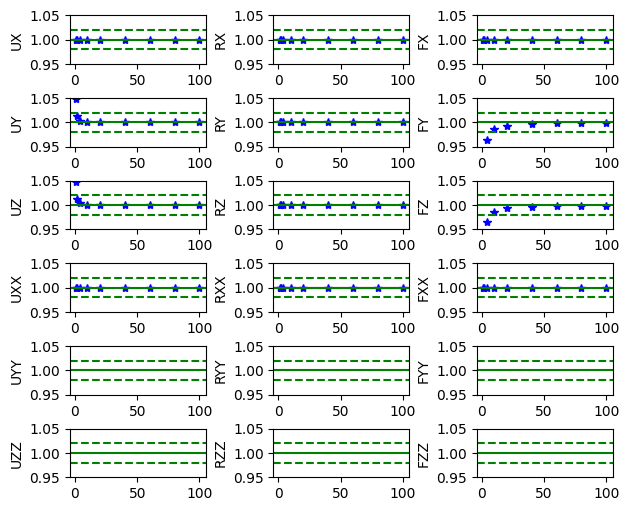

In [11]:
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 6))  # in inches
gs = gridspec.GridSpec(6, 3, hspace=0.7, wspace=0.5)
axes = []
# --------------------- DISPLACEMENTS --------------------

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylabel('UX')
ax1.plot(ns, ux, 'b*')

ax2 = fig.add_subplot(gs[1, 0])
ax2.set_ylabel('UY')
ax2.plot(ns, uy, 'b*')

ax3 = fig.add_subplot(gs[2, 0])
ax3.set_ylabel('UZ')
ax3.plot(ns, uz, 'b*')

ax4 = fig.add_subplot(gs[3, 0])
ax4.set_ylabel('UXX')
ax4.plot(ns, uxx, 'b*')

ax5 = fig.add_subplot(gs[4, 0])
ax5.set_ylabel('UYY')
ax5.plot(ns, uyy, 'b*')

ax6 = fig.add_subplot(gs[5, 0])
ax6.set_ylabel('UZZ')
ax6.plot(ns, uzz, 'b*')

# --------------------- REACTIONS --------------------

ax7 = fig.add_subplot(gs[0, 1])
ax7.set_ylabel('RX')
ax7.plot(ns, rx, 'b*')

ax8 = fig.add_subplot(gs[1, 1])
ax8.set_ylabel('RY')
ax8.plot(ns, ry, 'b*')

ax9 = fig.add_subplot(gs[2, 1])
ax9.set_ylabel('RZ')
ax9.plot(ns, rz, 'b*')

ax10 = fig.add_subplot(gs[3, 1])
ax10.set_ylabel('RXX')
ax10.plot(ns, rxx, 'b*')
ax10.axhline(y=1, color='r', linestyle='-')
ax10.set_ylim([0, 2])

ax11 = fig.add_subplot(gs[4, 1])
ax11.set_ylabel('RYY')
ax11.plot(ns, ryy, 'b*')

ax12 = fig.add_subplot(gs[5, 1])
ax12.set_ylabel('RZZ')
ax12.plot(ns, uzz, 'b*')

# --------------------- INTERNAL FORCES --------------------

ax13 = fig.add_subplot(gs[0, 2])
ax13.set_ylabel('FX')
ax13.plot(ns, fx, 'b*')

ax14 = fig.add_subplot(gs[1, 2])
ax14.set_ylabel('FY')
ax14.plot(ns, fy, 'b*')

ax15 = fig.add_subplot(gs[2, 2])
ax15.set_ylabel('FZ')
ax15.plot(ns, fz, 'b*')

ax16 = fig.add_subplot(gs[3, 2])
ax16.set_ylabel('FXX')
ax16.plot(ns, fxx, 'b*')

ax17 = fig.add_subplot(gs[4, 2])
ax17.set_ylabel('FYY')
ax17.plot(ns, fyy, 'b*')

ax18 = fig.add_subplot(gs[5, 2])
ax18.set_ylabel('FZZ')
ax18.plot(ns, fzz, 'b*')

axes.append(ax1)
axes.append(ax2)
axes.append(ax3)
axes.append(ax4)
axes.append(ax5)
axes.append(ax6)
axes.append(ax7)
axes.append(ax8)
axes.append(ax9)
axes.append(ax10)
axes.append(ax11)
axes.append(ax12)
axes.append(ax13)
axes.append(ax14)
axes.append(ax15)
axes.append(ax16)
axes.append(ax17)
axes.append(ax18)

for ax in axes:
    ax.axhline(y=1.02, color='g', linestyle='--')
    ax.axhline(y=1, color='g', linestyle='-')
    ax.axhline(y=0.98, color='g', linestyle='--')
    ax.set_ylim([0.95, 1.05])
